In [28]:
import os
os.chdir("/Users/ulrikah/fag/thesis/rave")


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

from rave.sound import Sound
from rave.effect import Effect
from rave.analyser import Analyser
from rave.constants import KSMPS, SAMPLE_RATE
from rave.tools import sec_per_k, timestamp

**Analysis**

Files to analyse (in `results/grid_search_target_entropy-lr3e-3`):

```
target_entropy_24_1000iters_debug.wav
target_entropy_24_1000iters.wav
target_entropy_12_1000iters_debug.wav
target_entropy_12_1000iters.wav
target_entropy_6_1000iters_debug.wav
target_entropy_6_1000iters.wav
```

What I want to get out:
- RMS plot of bounced_files
- pitch plot of bounces_files
- spectral plot of bounced_files
- upsampled control rate params on top of each other
- reward

**Retrieving the features**

In [30]:
feature_extractors = ["rms", "pitch", "spectral"]
analyser = Analyser(feature_extractors)
base_dir = "/Users/ulrikah/fag/thesis/results/grid_search_target_entropy-lr3e-3"

entropy_6 = os.path.join(base_dir, "target_entropy_6_1000iters.wav")
entropy_12 = os.path.join(base_dir, "target_entropy_12_1000iters.wav")
entropy_24 = os.path.join(base_dir, "target_entropy_24_1000iters.wav")

target     = "/Users/ulrikah/fag/thesis/rave/rave/input_audio/amen_5s.wav"
source     = "/Users/ulrikah/fag/thesis/rave/rave/input_audio/noise_5s.wav"

entropy_6_sound = Sound(entropy_6)
entropy_12_sound = Sound(entropy_12)
entropy_24_sound = Sound(entropy_24)

target_sound = Sound(target)
source_sound = Sound(source)

sounds = [entropy_6_sound, entropy_12_sound, entropy_24_sound, target_sound, source_sound]
for sound in sounds:
    sound.prepare_to_render(analyser=analyser)
    sound.features = []

done = False

while not done:
    for sound in sounds:
        done = done or sound.render()
        channel_values = sound.player.get_channels(analyser.analysis_features)
        sound.features.append(channel_values)
print("Number of feature vectors", [len(s.features) for s in sounds])
print("(sr / ksmps) * duration", (SAMPLE_RATE / KSMPS) * sounds[0].duration)

Number of feature vectors [1724, 1724, 1724, 1724, 1724]
(sr / ksmps) * duration 1722.9999999999998


## Visualisation

In [31]:
def clean_csound_name(csound_var):
    """
    e.g. 
    kcentroid_l -> centroid
    aenv -> env
    """
    return csound_var[1:].split("_")[0]

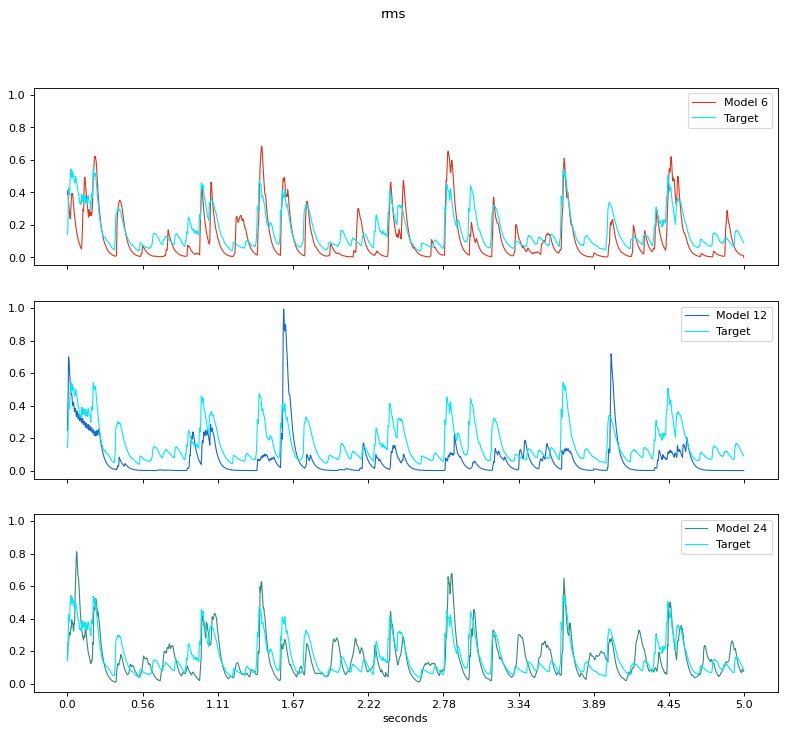

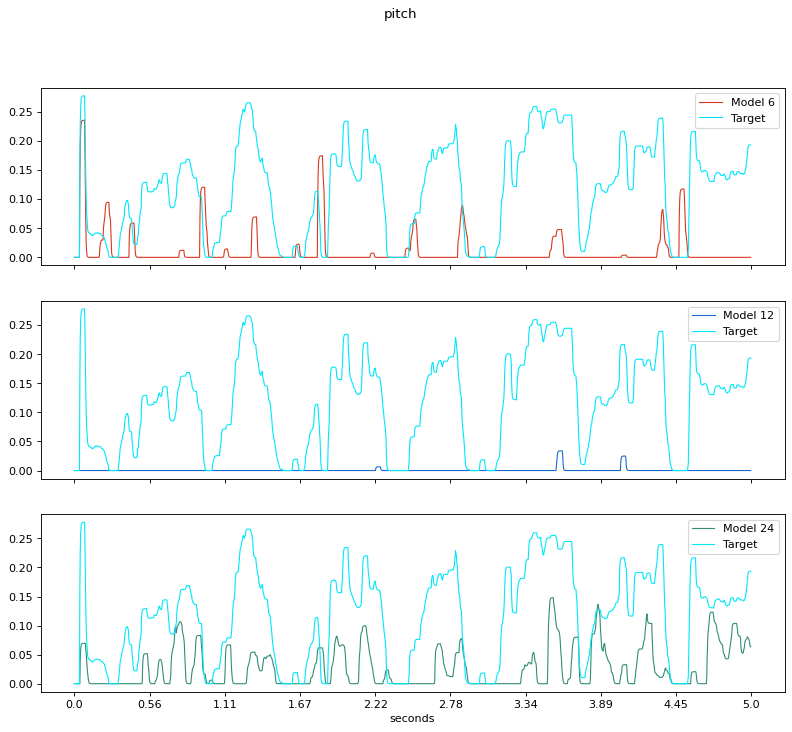

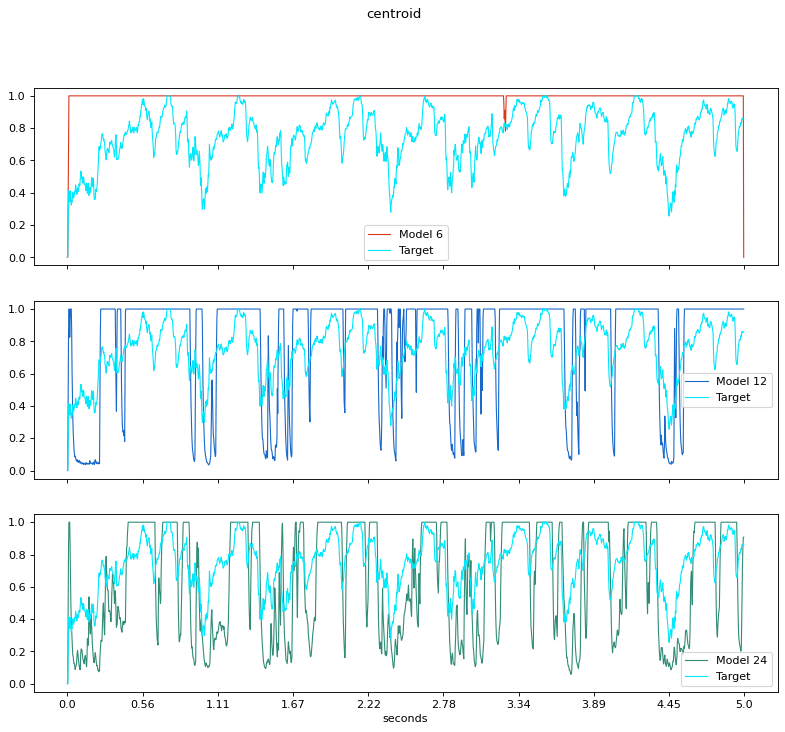

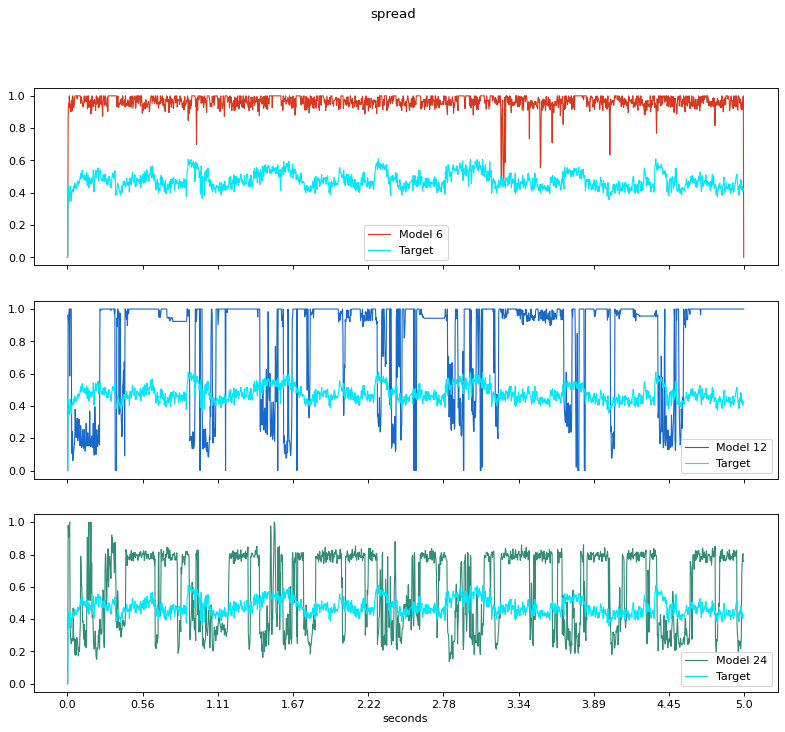

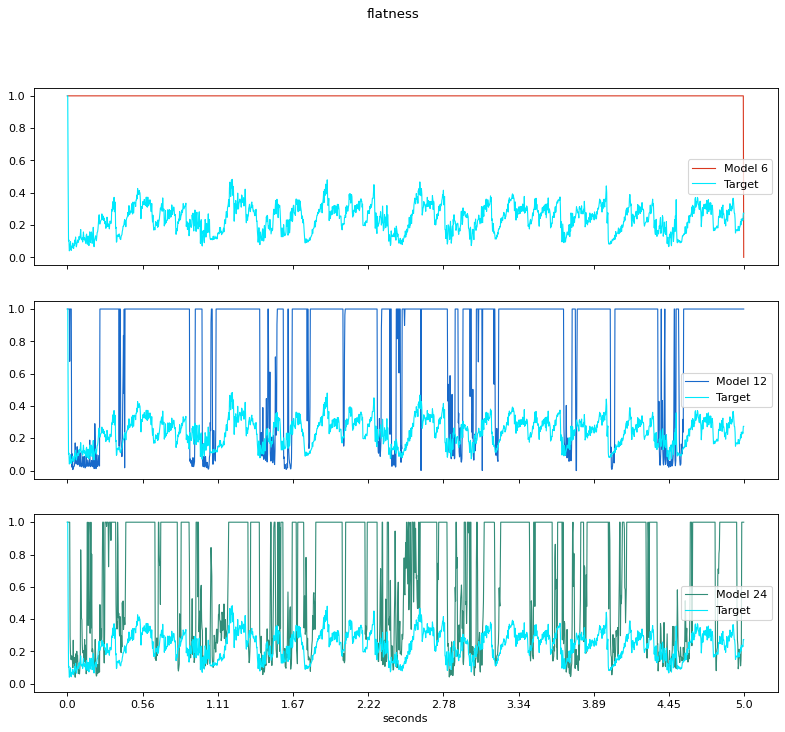

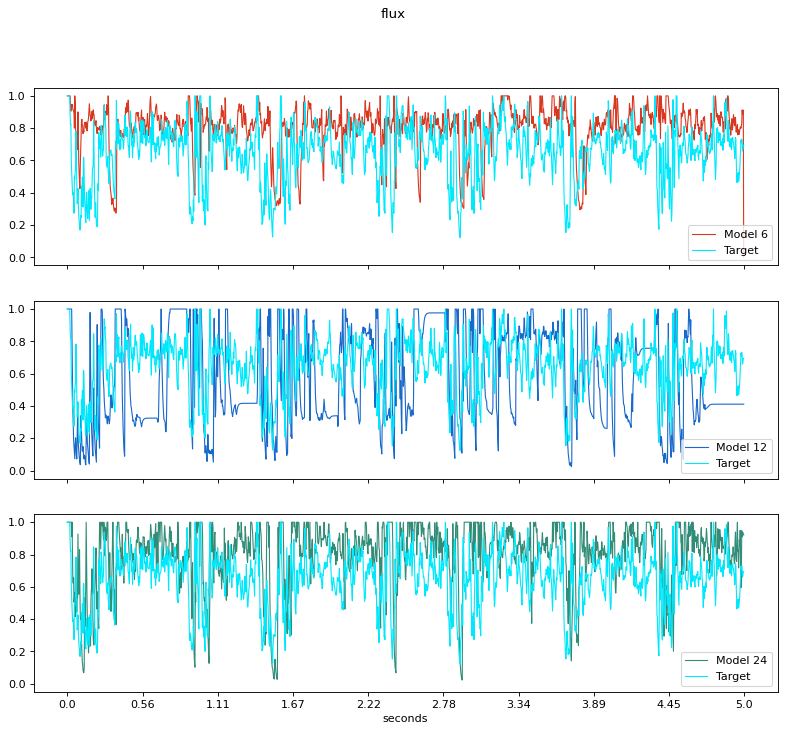

In [36]:
# numpyify
for sound in sounds:
    sound.features = np.array(sound.features)

sound_names = ["Model 6", "Model 12" ,"Model 24", "Target", "Source"]
sound_colors = [
    np.array([0.85181538, 0.22025192, 0.12469306]), 
    np.array([0.0950709 , 0.41044936, 0.79145089]),
    np.array([0.19786649, 0.55163671, 0.47055379]),
    np.array([0, 0.90980392, 0.98823529]), # light blue
    np.array([0.97647059, 0.78431373, 0.2745098 ]), # yellow 

]

n_frames = len(sounds[0].features)
n_xticks = 10
xtick_values = np.linspace(0, n_frames, num=n_xticks)
xtick_labels = [str(round(tick, 2)) for tick in xtick_values * sec_per_k(KSMPS, SAMPLE_RATE)]


entropy_6_index = 0
entropy_12_index = 1
entropy_24_index = 2

target_index = 3
source_index = 4

feature_names = [clean_csound_name(f) for f in analyser.analysis_features]


t = timestamp()

for i, feature_name in enumerate(feature_names):

    fig, axs = plt.subplots(3, figsize=(12,10), dpi=80, sharex=True, sharey=True)
    fig.suptitle(feature_name)
    plt.xticks(xtick_values, xtick_labels)
    plt.xlabel("seconds")

    # get values for current feature
    entropy_6_feature = sounds[entropy_6_index].features[:n_frames,i]
    entropy_12_feature = sounds[entropy_12_index].features[:n_frames,i]
    entropy_24_feature = sounds[entropy_24_index].features[:n_frames,i]

    target_feature = sounds[target_index].features[:n_frames,i]
    source_feature = sounds[source_index].features[:n_frames,i]

    #fig = plt.figure(figsize=(12,10), dpi=80)
    #fig.suptitle(feature_name, x=0.5, y=.98, size="xx-large", weight="bold", va="center", ha="center")
    #fig.subplots_adjust(top=0.95)
    
    # plt.subplot(2, 1, 1)
    axs[0].plot(entropy_6_feature, c=sound_colors[entropy_6_index], label=f"{sound_names[entropy_6_index]}", linewidth=1, markersize=12)
    axs[0].plot(target_feature, c=sound_colors[target_index], label=f"{sound_names[target_index]}", linewidth=1, markersize=12)
    axs[0].legend()

    # plt.subplot(2, 1, 2)
    axs[1].plot(entropy_12_feature, c=sound_colors[entropy_12_index], label=f"{sound_names[entropy_12_index]}", linewidth=1, markersize=12)
    axs[1].plot(target_feature, c=sound_colors[target_index], label=f"{sound_names[target_index]}", linewidth=1, markersize=12)
    axs[1].legend()

    # plt.subplot(2, 1, 3)
    axs[2].plot(entropy_24_feature, c=sound_colors[entropy_24_index], label=f"{sound_names[entropy_24_index]}", linewidth=1, markersize=12)
    axs[2].plot(target_feature, c=sound_colors[target_index], label=f"{sound_names[target_index]}", linewidth=1, markersize=12)
    axs[2].legend()

    # plt.savefig(f"rave/plots/feature_target_entropy_search_{feature_name}_{t}.png", transparent=True, dpi=200)
    plt.show()

## Visualize multi-track debug files

What I want to visualize:
- amen break (target)
- control channels for both debug files on top of each other

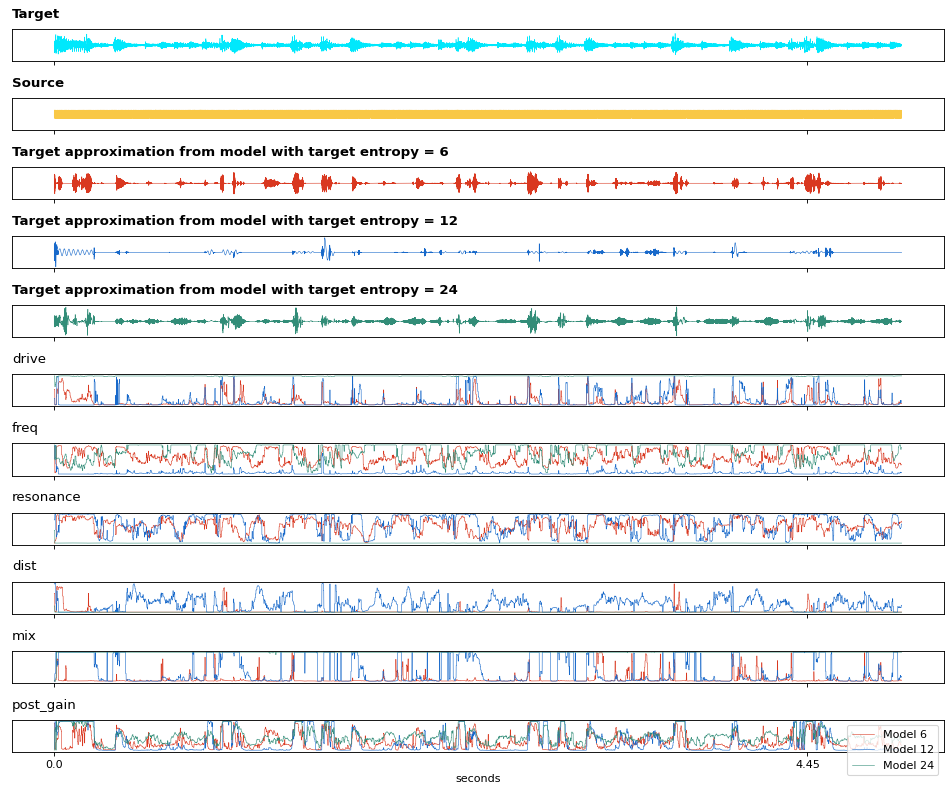

In [33]:
rms_debug = "/Users/ulrikah/fag/thesis/results/analysis/rms_1000iters_debug.wav"
all_debug = "/Users/ulrikah/fag/thesis/results/analysis/all_1000iters_debug.wav"

entropy_6_debug = os.path.join(base_dir, "target_entropy_6_1000iters_debug.wav")
entropy_12_debug = os.path.join(base_dir, "target_entropy_12_1000iters_debug.wav")
entropy_24_debug = os.path.join(base_dir, "target_entropy_24_1000iters_debug.wav")

effect = Effect("dist_lpf")
channel_names = list(map(lambda param: param.name, effect.parameters))

entropy_6_y, _ = librosa.load(entropy_6_debug, sr=SAMPLE_RATE, mono=False)
entropy_12_y, _ = librosa.load(entropy_12_debug, sr=SAMPLE_RATE, mono=False)
entropy_24_y, _ = librosa.load(entropy_24_debug, sr=SAMPLE_RATE, mono=False)

target_y, _ = librosa.load(target, sr=SAMPLE_RATE, mono=True)
source_y, _ = librosa.load(source, sr=SAMPLE_RATE, mono=True)

### Plotting ###
n_samples = entropy_12_y.size
n_xticks = 10
xtick_values = np.linspace(0, n_samples, num=n_xticks)
xtick_labels = [str(round(tick, 2)) for tick in xtick_values / SAMPLE_RATE]

fig, axs = plt.subplots(nrows=11, ncols=1, sharex=True, sharey=True, figsize=(12,10), dpi=80)
plt.yticks([])
plt.xticks(xtick_values, xtick_labels)
plt.xlabel("seconds")

axs[0].plot(target_y, c=sound_colors[target_index], linewidth=.5, markersize=12)
axs[0].set_title(label="Target", loc="left", pad="10", weight="bold")

axs[1].plot(source_y, c=sound_colors[source_index], linewidth=.5, markersize=12)
axs[1].set_title(label="Source", loc="left", pad="10", weight="bold")

axs[2].plot(entropy_6_y[1], c=sound_colors[entropy_6_index], linewidth=.5, markersize=12)
axs[2].set_title(label="Target approximation from model with target entropy = 6", loc="left", pad="10", weight="bold")

axs[3].plot(entropy_12_y[1], c=sound_colors[entropy_12_index], linewidth=.5, markersize=12)
axs[3].set_title(label="Target approximation from model with target entropy = 12", loc="left", pad="10", weight="bold")

axs[4].plot(entropy_24_y[1], c=sound_colors[entropy_24_index], linewidth=.5, markersize=12)
axs[4].set_title(label="Target approximation from model with target entropy = 24", loc="left", pad="10", weight="bold")

# the first two channels in the debug waveform are the dry and wet, i.e. [dry, wet, ...parameters] so we offset by 2
# assert y.shape[0] == len(channel_names) + 2
for i in range(2, 8): # omit the dry and wet channels
    axs[i+3].plot(entropy_6_y[i], c=sound_colors[entropy_6_index], linewidth=.5, markersize=12, label="6")
    axs[i+3].plot(entropy_12_y[i], c=sound_colors[entropy_12_index], linewidth=.5, markersize=12, label="12")
    axs[i+3].plot(entropy_24_y[i], c=sound_colors[entropy_24_index], linewidth=.5, markersize=12, label="24")
    axs[i+3].set_title(label=channel_names[i - 2], loc="left", pad="10")

fig.tight_layout()
plt.legend(["Model 6", "Model 12", "Model 24"], loc='upper right')
_t = timestamp()
plt.savefig(f"rave/plots/controls_entropy_search_{t}.png", transparent=True, dpi=200)
plt.show()